<a href="https://colab.research.google.com/github/tilakparth/Automatic-Image-Captioning/blob/main/Automatic_Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
import pickle
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

In [2]:
def load_document(filename):
	# opening the file as read only
	file = open(filename, 'r')
	# reading all text
	text = file.read()
	# closing the file
	file.close()
	return text

filename = "/content/drive/MyDrive/flicker8k/Flickr_Data/Flickr_TextData/Flickr8k.token.txt"
# loading descriptions
doc = load_document(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [3]:
def load_descriptions(doc):
	mapping = dict()
	# processing lines
	for line in doc.split('\n'):
		# spliting line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# taking the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extracting filename from image id
		image_id = image_id.split('.')[0]
		# converting description tokens back to string
		image_desc = ' '.join(image_desc)
		# creating the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# storing description
		mapping[image_id].append(image_desc)
	return mapping

# parsing descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [4]:
list(descriptions.keys())[0:10]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615',
 '1007320043_627395c3d8',
 '1009434119_febe49276a',
 '1012212859_01547e3f17',
 '1015118661_980735411b',
 '1015584366_dfcec3c85a']

In [5]:
descriptions['1007320043_627395c3d8']

['A child playing on a rope net .',
 'A little girl climbing on red roping .',
 'A little girl in pink climbs a rope bridge at the park .',
 'A small child grips onto the red ropes at the playground .',
 'The small child climbs on a red ropes on a playground .']

In [6]:
def clean_descriptions(descriptions):
	# preparing translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenizing
			desc = desc.split()
			# converting to lower case
			desc = [word.lower() for word in desc]
			# removing punctuation from each token
			desc = [w.translate(table) for w in desc]
			# removing hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# removing tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# storing as string
			desc_list[i] =  ' '.join(desc)

# cleaning descriptions
clean_descriptions(descriptions)

In [7]:
descriptions['1007320043_627395c3d8']

['child playing on rope net',
 'little girl climbing on red roping',
 'little girl in pink climbs rope bridge at the park',
 'small child grips onto the red ropes at the playground',
 'the small child climbs on red ropes on playground']

In [8]:
# converting the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# building a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarizing vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [9]:
# saving descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [10]:
# loading a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_document(filename)
	dataset = list()
	# processing line by line
	for line in doc.split('\n'):
		# skiping empty lines
		if len(line) < 1:
			continue
		# geting the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# loading training dataset (6K)
filename = '/content/drive/MyDrive/flicker8k/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
train = load_set(filename)
# print(train)
# print('Dataset: %d' % len(train))

In [11]:
# Below path contains all the images
images = '/content/drive/MyDrive/flicker8k/Flickr_Data/Images/'
# Creating a list of all image names in the directory
img = glob.glob(images + '*?.jpg')

In [12]:
# Below file conatains the names of images to be used in train data
train_images_file = '/content/drive/MyDrive/flicker8k/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
# Reading the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
# Creating a list of all the training images with their full path names

train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Checking if the image belongs to training set
        train_img.append(i) # Adding it to the list of train images

In [13]:
# Below file conatains the names of images to be used in test data
test_images_file = '/content/drive/MyDrive/flicker8k/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'
# Reading the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Creating a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Checking if the image belongs to test set
        test_img.append(i) # Adding it to the list of test images

In [14]:
# loading clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# loading document
	doc = load_document(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# spliting line by white space
		tokens = line.split()
		# spliting id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skiping images not in the set
		if image_id in dataset:
			# creating list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wraping description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# storing
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [15]:
def preprocess(image_path):
    # Converting all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Converting PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Adding one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocessing the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [16]:
# Loading the inception v3 model
model = InceptionV3(weights='imagenet')

96124928/96112376 [==============================] - 2s 0us/step


In [17]:
# Creating a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [18]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocessing the image
    fea_vec = model_new.predict(image) # Geting the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshaping from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
# Calling the funtion to encode all the train images
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

In [ ]:
# Saving the bottleneck train features to disk so that i don't have to encode it again and again 
with open("/content/drive/MyDrive/flicker8k/Flickr_Data/Pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [ ]:
# Calling the funtion to encode all the test images
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 580.6892600059509


In [ ]:
# Saving the bottleneck test features to disk to save my time
with open("/content/drive/MyDrive/flicker8k/Flickr_Data/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [19]:
train_features = load(open("/content/drive/MyDrive/flicker8k/Flickr_Data/Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [20]:
train_features['1000268201_693b08cb0e.jpg']

array([0.12277611, 0.33294964, 0.75271726, ..., 0.21939704, 0.3021639 ,
       0.40283126], dtype=float32)

In [21]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [22]:
# Creating a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [23]:
# Considering only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [24]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [25]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [26]:
# converts a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculating the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)  # list of all captions
	return max(len(d.split()) for d in lines)

# determining the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length) 

Description Length: 34


In [27]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    # X- INPUT y - OUTPUR
    X1, X2, y = list(), list(), list()
    n=0
    # looping for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieving the photo feature
            photo = photos[key+'.jpg']  # feature vector
            for desc in desc_list:
                # encoding the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # spliting one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # spliting into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pading input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encoding output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # storing
                    X1.append(photo)  # feature vector
                    X2.append(in_seq) # padded input sequence
                    y.append(out_seq) # encoded output sequence
            # yielding the batch data
            if n==num_photos_per_batch:
                yield ((array(X1), array(X2)), array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [27]:
embeddings_index = {} # empty dictionary
f = open('/content/drive/MyDrive/flicker8k/Flickr_Data/glove/glove.6B.200d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [28]:
embedding_dim = 200

# Geting 200-dim dense vector for each of the 1652 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [29]:
embedding_matrix.shape

(1652, 200)

In [30]:
inputs1 = Input(shape=(2048,)) # feature vector
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,)) # word sequence
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [31]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [32]:
model.layers[2]

In [33]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [34]:
model.compile(loss='categorical_crossentropy')

In [36]:

epochs = 10
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [37]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/content/drive/MyDrive/flicker8k/model_weights' + str(i) + '.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


2000/2000 [==============================] - 277s 127ms/step - loss: 4.6804


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2000/2000 [==============================] - 254s 127ms/step - loss: 3.7358


In [38]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/content/drive/MyDrive/flicker8k/model_weights/model_weight_' + str(i) + '.h5')

   1/2000 [..............................] - ETA: 4:06 - loss: 3.6395

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


2000/2000 [==============================] - 251s 126ms/step - loss: 3.8002


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2000/2000 [==============================] - 254s 127ms/step - loss: 3.8538


In [39]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_batch = 6
steps = len(train_descriptions)//number_pics_per_batch

In [41]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights/model_' + str(i) + '.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1000/1000 [==============================] - 141s 141ms/step - loss: 3.4379


In [43]:
model.save_weights('/content/drive/MyDrive/flicker8k/model_weights/model_30.h5')

In [35]:

model.load_weights('/content/drive/MyDrive/flicker8k/model_weights/model_30.h5')

In [36]:
with open("/content/drive/MyDrive/flicker8k/Flickr_Data/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [38]:
encoding_test['106490881_5a2dd9b7bd.jpg']

array([0.4193288 , 0.19502951, 0.11467594, ..., 0.3960291 , 1.3721385 ,
       0.24658443], dtype=float32)

In [39]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [46]:
images = '/content/drive/MyDrive/flicker8k/Flickr_Data/Images/'
z = 0

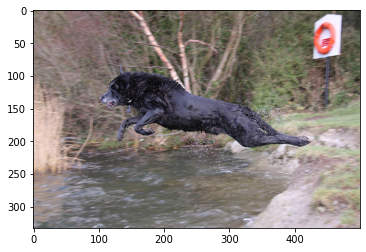

Greedy: dog is running through the water


In [58]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))   # quite accurate

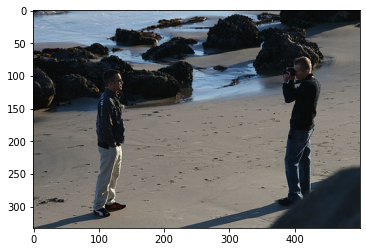

Greedy: two children are playing in the water


In [59]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))  # somewhat accurate

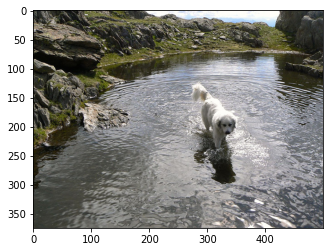

Greedy: dog is running through the water


In [60]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image)) # perfect 

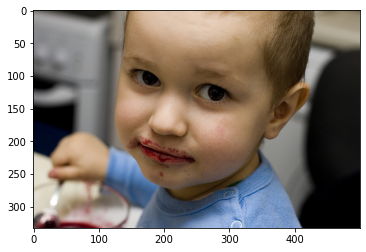

Greedy: little girl in pink shirt is playing with ball


In [67]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image)) # very less acuurate

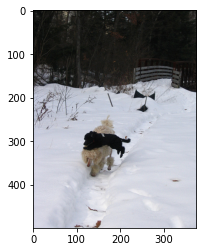

Greedy: dog is running through the snow


In [69]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image)) #highly accurate

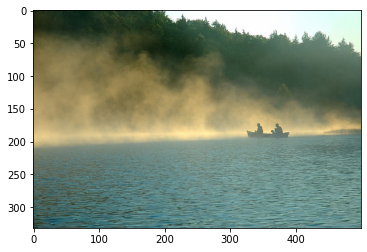

Greedy: man in black shirt is standing on the beach


In [70]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image)) ## very less acuurate

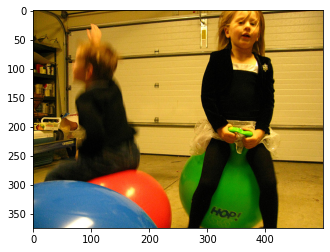

Greedy: two young girls are playing in the grass


In [71]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image)) # somewhat accurate

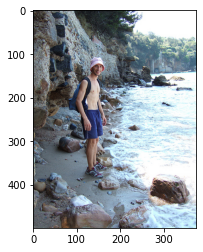

Greedy: man in red shirt is climbing rock wall


In [72]:
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image)) #very less accurate